### Llamadas 911 desde el primer semestre del 2019 hasta el primer semestre del 2022

In [30]:
### Importar librerías
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Concatenate, Embedding, Dropout, BatchNormalization, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

In [17]:
### Combinación de múltiples archivos CSV en uno solo

# Ruta a la carpeta donde están los archivos CSV
ruta_archivos = './Datos/'

# Nombre del archivo combinado
archivo_combinado = './Datos/llamadas_911_combinado.csv'

# Verificar si el archivo combinado ya existe
if os.path.exists(archivo_combinado):
    print(f"El archivo '{archivo_combinado}' ya existe. No se realizará la combinación.")
else:
    # Especifica el patrón de los archivos CSV
    archivo_csv = glob.glob(ruta_archivos + 'llamadas_911_*.csv')

    # Lista para almacenar tamaños de cada archivo
    tamanos_individuales = {}

    # Leer cada archivo, manejar errores de codificación y contar filas
    dataframes = []
    for archivo in archivo_csv:
        nombre_archivo = archivo.split('/')[-1]
        try:
            df = pd.read_csv(archivo, encoding='ISO-8859-1')
        except UnicodeDecodeError:
            df = pd.read_csv(archivo, encoding='cp1252')
        dataframes.append(df)
        tamanos_individuales[nombre_archivo] = df.shape[0]

    # Combinar todos los DataFrames en uno solo
    df_combinado = pd.concat(dataframes, ignore_index=True)

    # Guardar el DataFrame combinado en un archivo CSV
    df_combinado.to_csv(archivo_combinado, index=False)

    # Calcular la suma de los tamaños individuales
    suma_tamanos_individuales = sum(tamanos_individuales.values())
    print(f"Se combinó un total de {suma_tamanos_individuales} filas en '{archivo_combinado}'.")

El archivo './Datos/llamadas_911_combinado.csv' ya existe. No se realizará la combinación.


In [2]:
### Primer análisis del DataFrame combinado

# Abrir el archivo CSV combinado
df_llamadas = pd.read_csv('./Datos/llamadas_911_combinado.csv')
# Unificar etiquetas similares
df_llamadas['codigo_cierre'] = df_llamadas['codigo_cierre'].replace({'Afirmativo': 'A', 'Negativo': 'N', 'Duplicado': 'D', 'Informativo': 'I', 'Falso': 'F'})

In [86]:
# # Columnas del DataFrame
# print(df_llamadas.columns)

In [ ]:
# # Regresar los valores únicos de las columnas 'categoria_incidente_c4'
# categorias_incidente = df_llamadas['categoria_incidente_c4'].unique()
# print("\nCategorías de incidentes reportados:")
# print(categorias_incidente)


Categorías de incidentes reportados:
['Medicos' 'Denuncia' 'Danos' 'Servicios' 'Robo' 'Disturbio' 'Incendio'
 'Agresion' 'Danos por fenomeno natural o tercero'
 'Privacion de la libertad' 'Denuncia de hechos' 'Amenaza' 'Lesionado'
 'Derrame o fuga' 'Contra la salud' 'Administrativas'
 'Detencion ciudadana' 'Cadaver' 'Abandono' 'Explosion' 'Abandono '
 'Sismo' 'Accidente' 'Electorales' 'Intento de suicidio' nan
 'Persona extraviada en zona boscosa']


In [3]:
# Conteo de valores únicos en la columna 'categoria_incidente_c4'
conteo_categorias = df_llamadas['codigo_cierre'].value_counts()
print("\nConteo de incidentes reportados:")
print(conteo_categorias)


Conteo de incidentes reportados:
N        1256844
A        1120401
Otros     985637
D         738471
F          15225
I           1354
Name: codigo_cierre, dtype: int64


In [85]:
# # Regresar los valores únicos de las columnas 'codigo_cierre'
# categorias_incidente = df_llamadas['anio_creacion'].unique()
# print("\nCategorías de cierres:")
# print(categorias_incidente)

In [84]:
# # Asegúrate de que la columna de fecha esté en formato datetime
# df_llamadas['fecha_cierre'] = pd.to_datetime(df_llamadas['fecha_cierre'], errors='coerce')

# # Crear una columna de año-mes para el conteo
# df_llamadas['anio_mes'] = df_llamadas['fecha_cierre'].dt.to_period('M')

# # Contar llamadas por año-mes
# conteo_mensual = df_llamadas.groupby('anio_mes').size()

# # Rellenar meses faltantes con 0
# conteo_mensual = conteo_mensual.reindex(pd.period_range(start=df_llamadas['anio_mes'].min(),
#                                                         end=df_llamadas['anio_mes'].max(), freq='M'), fill_value=0)

# # Convertir a DataFrame para visualización
# conteo_mensual_df = conteo_mensual.reset_index()
# conteo_mensual_df.columns = ['Mes', 'Total_Llamadas']

# # Mostrar el DataFrame con el conteo mensual incluyendo meses con 0
# conteo_mensual_df

# # Graficar el conteo mensual de llamadas
# plt.figure(figsize=(12, 6))
# plt.plot(conteo_mensual_df['Mes'].astype(str), conteo_mensual_df['Total_Llamadas'], marker='o')
# plt.xticks(rotation=45)
# plt.xlabel('Mes')
# plt.ylabel('Total de Llamadas')
# plt.title('Total de Llamadas al 911 por Mes')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [83]:
# ### Verificar cantidad de NaNs en el DataFrame
# print("\nCantidad de valores nulos por columna:")
# print(df_llamadas.isnull().sum())

# # # Ver qué características tienen las filas donde 'categoria_incidente_c4' es nulo en contraste con el total de filas
# # print("\nFilas con 'categoria_incidente_c4' nulo:")
# # print(df_llamadas[df_llamadas['categoria_incidente_c4'].isnull()])

# # Contar cuántas filas tienen 'categoria_incidente_c4'
# conteo_categoria_incidente = df_llamadas['categoria_incidente_c4'].count()
# total_filas = df_llamadas.shape[0]
# print(f"\nPorcentaje de filas con 'categoria_incidente_c4' no nulo: {conteo_categoria_incidente / total_filas:.2%}")

# # Eliminar filas con 'categoria_incidente_c4' nulo
# df_llamadas = df_llamadas.dropna(subset=['categoria_incidente_c4'])


---
## Diseño del Modelo
### Entrada Geográfica (CNN):

- Convertir las coordenadas en cuadrículas para capturar patrones espaciales relacionados con los tipos de cierre (codigo_cierre). \
- La CNN detectará patrones de áreas geográficas con alta frecuencia de llamadas reales, falsas, etc.

### Entrada Temporal (LSTM):

- Usar datos como el día del año, la hora y otras características temporales para capturar estacionalidad y patrones temporales.
- La LSTM identificará tendencias en las llamadas relacionadas con temporadas o días específicos.

### Concatenación y Clasificación:

- Combinar las salidas de CNN y LSTM.
- Añadir una capa densa para predecir la probabilidad de cada clase de codigo_cierre.

### Procesamiento de datos

#### 1.1 Datos Espaciales
El modelo CNN espera una entrada en forma de matriz (10x10 en este caso). Sigue estos pasos para transformar las coordenadas en cuadrículas: \
Paso 1: Normalizar las coordenadas (latitud, longitud) para que estén en un rango uniforme. \
Paso 2: Dividir las coordenadas en una cuadrícula (e.g., 10x10). \
Paso 3: Crear una matriz de frecuencia para cada cuadrícula (representando la intensidad de llamadas en cada región).

#### 1.2 Datos Temporales (fecha_creacion, hora_creacion)
El modelo LSTM espera datos en formato de secuencia temporal. Aquí transformaremos los datos:

- Paso 1: Extraer características temporales relevantes como el día de la semana, hora, mes, etc.
- Paso 2: Agrupar llamadas en secuencias de tiempo (e.g., 24 horas).

#### 1.3 Categoría del Incidente (categoria_incidente_c4)
La columna categoria_incidente_c4 necesita ser convertida en un índice o embedding:

- Paso 1: Convertir las categorías en índices únicos.
- Paso 2: Pasar estos índices al modelo como entrada para embeddings.

In [39]:
# import matplotlib.pyplot as plt

# Contar la cantidad de ocurrencias de cada clase en 'codigo_cierre'
clase_counts = df_llamadas['codigo_cierre'].value_counts()
# Mostrar la distribución de las clases
print(clase_counts)

# # Visualizar el balance de las clases en un gráfico de barras
# plt.figure(figsize=(10, 6))
# clase_counts.plot(kind='bar')
# plt.xlabel('Clase de Cierre')
# plt.ylabel('Número de Llamadas')
# plt.title('Distribución de las Clases en "codigo_cierre"')
# plt.show()


N        1256844
A        1120401
Otros     985637
D         738471
F          15225
I           1354
Name: codigo_cierre, dtype: int64


---

In [16]:
# ---- 1. Procesar Datos Espaciales (latitud, longitud) ----

# Eliminar columnas no necesarias para reducir uso de memoria
columnas_utilizadas = ['latitud', 'longitud', 'fecha_creacion', 'hora_creacion', 'codigo_cierre']
df_llamadas = df_llamadas[columnas_utilizadas]

# Hacer una copia del DataFrame para evitar el SettingWithCopyWarning
df_llamadas = df_llamadas.copy()

# Normalización de las coordenadas latitud y longitud
df_llamadas['lat_norm'] = (df_llamadas['latitud'] - df_llamadas['latitud'].min()) / (df_llamadas['latitud'].max() - df_llamadas['latitud'].min())
df_llamadas['lon_norm'] = (df_llamadas['longitud'] - df_llamadas['longitud'].min()) / (df_llamadas['longitud'].max() - df_llamadas['longitud'].min())

# Crear una cuadrícula con una resolución definida por el tamaño de la cuadrícula
grid_size = 50
df_llamadas['lat_bin'] = (df_llamadas['lat_norm'] * (grid_size - 1)).astype(int)
df_llamadas['lon_bin'] = (df_llamadas['lon_norm'] * (grid_size - 1)).astype(int)


# Crear matriz para CNN
X_cnn = np.zeros((len(df_llamadas), grid_size, grid_size, 1), dtype=np.float32)
for idx, row in df_llamadas.iterrows():
    if idx < len(X_cnn) and 0 <= row['lat_bin'] < grid_size and 0 <= row['lon_bin'] < grid_size:
        X_cnn[idx, row['lat_bin'], row['lon_bin'], 0] = 1

In [17]:
# ---- 2. Procesar Datos Temporales (fecha_creacion, hora_creacion) ----

# Convertir fecha a datetime, forzando la conversión y filtrando fechas inválidas
df_llamadas['fecha_creacion'] = pd.to_datetime(df_llamadas['fecha_creacion'], errors='coerce')
df_llamadas = df_llamadas[df_llamadas['fecha_creacion'].notna()]

# Crear características temporales
df_llamadas['dia_semana'] = df_llamadas['fecha_creacion'].dt.dayofweek  # 0: Lunes, 6: Domingo

# Extraer la hora de 'hora_creacion' en formato HH:MM:SS
df_llamadas['hora'] = df_llamadas['hora_creacion'].str.split(':').str[0].astype(int)
df_llamadas['mes'] = df_llamadas['fecha_creacion'].dt.month

# Codificación sinusoidal para características cíclicas
df_llamadas['dia_semana_sin'] = np.sin(2 * np.pi * df_llamadas['dia_semana'] / 6.0)
df_llamadas['dia_semana_cos'] = np.cos(2 * np.pi * df_llamadas['dia_semana'] / 6.0)
df_llamadas['hora_sin'] = np.sin(2 * np.pi * df_llamadas['hora'] / 24.0)
df_llamadas['hora_cos'] = np.cos(2 * np.pi * df_llamadas['hora'] / 24.0)
df_llamadas['mes_sin'] = np.sin(2 * np.pi * df_llamadas['mes'] / 12.0)
df_llamadas['mes_cos'] = np.cos(2 * np.pi * df_llamadas['mes'] / 12.0)

# Definir la longitud de la secuencia
sequence_length = 24
step_size = 24

# Crear secuencias temporales utilizando un enfoque de ventana deslizante
data_temporal = df_llamadas[['hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos', 'mes_sin', 'mes_cos']].values.astype(np.float32)
X_lstm = [data_temporal[i:i+sequence_length] for i in range(0, len(data_temporal) - sequence_length, step_size)]
X_lstm = np.array(X_lstm)

In [28]:
# ---- 3. Procesar Etiquetas (codigo_cierre) ----

# Procesar etiquetas multiclase (A, I, N, D, F)
categoria_etiqueta_map = {'A': 0, 'I': 1, 'N': 2, 'D': 3, 'F': 4}
df_llamadas['codigo_cierre_idx'] = df_llamadas['codigo_cierre'].map(categoria_etiqueta_map).fillna(0).astype(int)

# Asegurarnos de que todos los valores estén en el rango correcto (0 a 4)
df_llamadas['codigo_cierre_idx'] = df_llamadas['codigo_cierre_idx'].clip(lower=0, upper=4)

# Convertir las etiquetas en formato one-hot
y = tf.keras.utils.to_categorical(df_llamadas['codigo_cierre_idx'].values[:len(X_lstm)], num_classes=5)

# Definir X_cat como la columna de los índices de las categorías (ya en el rango correcto)
X_cat = df_llamadas['codigo_cierre_idx'].values.reshape(-1, 1)

# ---- 4. Ajustar Dimensiones ----

# Ajustar tamaño de X_cnn para que coincida con X_lstm
X_cnn = X_cnn[:len(X_lstm)]

---

In [27]:
# # Revisar conteo de valores únicos en 'codigo_cierre_idx'
# conteo_clases = df_llamadas['codigo_cierre_idx'].value_counts().sort_index()
# print("\nConteo de clases:")
# print(conteo_clases)

# # Revisar la forma de los datos
# print(f"X_lstm shape: {X_lstm.shape}")  # Verifica si la forma es (n_samples, 24, 5)

# # Mostrar algunas muestras aleatorias de X_lstm
# random_indices = np.random.choice(len(X_lstm), 5, replace=False)
# for idx in random_indices:
#     print(f"Secuencia {idx}: {X_lstm[idx]}")


# # Calcular la media y desviación estándar para cada feature
# mean_values = np.mean(X_lstm, axis=(0, 1))
# std_values = np.std(X_lstm, axis=(0, 1))
# print(f"Media de las características: {mean_values}")
# print(f"Desviación estándar de las características: {std_values}")

# # Buscar valores atípicos
# outliers = np.where(X_lstm > (mean_values + 3 * std_values))
# if len(outliers[0]) > 0:
#     print(f"Valores atípicos encontrados en los índices: {outliers}")


In [14]:
# Imprimir las formas de las entradas y etiquetas para verificar
print(f"X_cnn shape: {X_cnn.shape}")
print(f"X_lstm shape: {X_lstm.shape}")
print(f"X_cat shape: {X_cat.shape}")
print(f"y shape: {y.shape}")


X_cnn shape: (4117908, 20, 20, 1)
X_lstm shape: (171580, 24, 6)
X_cat shape: (4117932, 1)
y shape: (4117908, 5)


In [ ]:
# ---- 6. Aumentar Complejidad de las Capas de Convolución ----

# Definir las entradas del modelo
input_cnn = Input(shape=(50, 50, 1), name='Input_CNN')
input_lstm = Input(shape=(24, 6), name='Input_LSTM')
input_category = Input(shape=(1,), name='Input_Category')

# Capas de Convolución (CNN) para el procesamiento espacial
x_cnn = Conv2D(16, (5, 5), padding='same', activation='relu')(input_cnn)
x_cnn = BatchNormalization()(x_cnn)
x_cnn = MaxPooling2D(pool_size=(2, 2))(x_cnn)  # Reduce a 25x25
x_cnn = Dropout(0.4)(x_cnn)  # Añadir dropout al 30%

x_cnn = Conv2D(32, (3, 3), padding='same', activation='relu')(x_cnn)
x_cnn = BatchNormalization()(x_cnn)
x_cnn = MaxPooling2D(pool_size=(2, 2))(x_cnn)  # Reduce a 12x12
x_cnn = Dropout(0.4)(x_cnn)  # Añadir dropout al 30%

x_cnn = Conv2D(64, (3, 3), padding='same', activation='relu')(x_cnn)
x_cnn = BatchNormalization()(x_cnn)
x_cnn = MaxPooling2D(pool_size=(2, 2))(x_cnn)  # Reduce a 6x6

x_cnn = Flatten()(x_cnn)

# Capas LSTM para el procesamiento temporal
x_lstm = LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(input_lstm)
x_lstm = LSTM(32, return_sequences=True)(x_lstm)
x_lstm = GlobalMaxPooling1D()(x_lstm)  # Reducir la dimensionalidad de la salida de LSTM
# x_lstm = BatchNormalization()(x_lstm)

# Capa de Embedding para el procesamiento de la categoría de cierre
x_cat = Embedding(input_dim=5, output_dim=4)(input_category)
x_cat = Flatten()(x_cat)

# Concatenar las salidas de las tres ramas
x = Concatenate()([x_cnn, x_lstm, x_cat])

# Capas densas y salida revisadas
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)  # Segunda capa densa con 32 unidades
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(5, activation='softmax', name='Output')(x)  # Capa de salida multiclase

# Definición del modelo
model = Model(inputs=[input_cnn, input_lstm, input_category], outputs=output, name='Spatial_Temporal_Model')

# Compilación
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar el resumen del modelo
model.summary()

# Definir callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Convertir etiquetas one-hot a etiquetas enteras (0, 1, 2, 3, 4)
y_labels = np.argmax(y, axis=1)

# Calcular los pesos de las clases
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_labels),
                                     y=y_labels)

# Convertir los pesos en un diccionario
class_weight_dict = dict(enumerate(class_weights))

# ---- 7. Entrenamiento del Modelo ----
history = model.fit([X_cnn, X_lstm, X_cat], y, batch_size=32, epochs=25, validation_split=0.3, callbacks=[reduce_lr, early_stopping, checkpoint], class_weight=class_weight_dict)

Model: "Spatial_Temporal_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_CNN (InputLayer)         [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 conv2d_26 (Conv2D)             (None, 50, 50, 16)   416         ['Input_CNN[0][0]']              
                                                                                                  
 batch_normalization_18 (BatchN  (None, 50, 50, 16)  64          ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_26 (MaxPooling2D  (None, 25, 25, 16)  0           ['batch_norm

KeyboardInterrupt: 

In [32]:
from graphviz import Digraph

# Crear un diagrama orientado de manera vertical con fondo transparente
dot = Digraph('Model_Architecture', format='png')

# Definir las características del gráfico
dot.attr(bgcolor='transparent', rankdir='TB', color='#DAFFFB', fontcolor='#DAFFFB')  # Fondo transparente y orientación vertical (top to bottom)

# Añadir nodos para cada capa del modelo
dot.node('Input_CNN', 'Input CNN (50x50x1)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Conv2D_1', 'Conv2D (16 filtros, 5x5)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('BatchNorm_1', 'Batch Normalization', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('MaxPooling_1', 'MaxPooling (25x25x16)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Dropout_1', 'Dropout (30%)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Conv2D_2', 'Conv2D (32 filtros, 3x3)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('BatchNorm_2', 'Batch Normalization', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('MaxPooling_2', 'MaxPooling (12x12x32)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Dropout_2', 'Dropout (30%)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Conv2D_3', 'Conv2D (64 filtros, 3x3)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('BatchNorm_3', 'Batch Normalization', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('MaxPooling_3', 'MaxPooling (6x6x64)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Flatten_CNN', 'Flatten (2304)', color='#DAFFFB', fontcolor='#DAFFFB')

# Añadir nodos para la rama LSTM
dot.node('Input_LSTM', 'Input LSTM (24x6)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('LSTM_1', 'LSTM (64 unidades)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('LSTM_2', 'LSTM (32 unidades)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('GlobalMaxPooling', 'Global Max Pooling (32)', color='#DAFFFB', fontcolor='#DAFFFB')

# Añadir nodos para la rama de categoría
dot.node('Input_Category', 'Input Category (1)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Embedding', 'Embedding (4 dim)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Flatten_Embedding', 'Flatten (4)', color='#DAFFFB', fontcolor='#DAFFFB')

# Añadir nodos para la concatenación y capas densas
dot.node('Concatenation', 'Concatenation', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Dense_1', 'Dense Layer (64 unidades)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('BatchNorm_Dense_1', 'Batch Normalization', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Dropout_Dense_1', 'Dropout (30%)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Dense_2', 'Dense Layer (32 unidades)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('BatchNorm_Dense_2', 'Batch Normalization', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Dropout_Dense_2', 'Dropout (30%)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Output', 'Output Layer (5 clases)', color='#DAFFFB', fontcolor='#DAFFFB')

# Añadir las relaciones entre las capas como tuplas y establecer color para los bordes
edges = [
    ('Input_CNN', 'Conv2D_1'),
    ('Conv2D_1', 'BatchNorm_1'),
    ('BatchNorm_1', 'MaxPooling_1'),
    ('MaxPooling_1', 'Dropout_1'),
    ('Dropout_1', 'Conv2D_2'),
    ('Conv2D_2', 'BatchNorm_2'),
    ('BatchNorm_2', 'MaxPooling_2'),
    ('MaxPooling_2', 'Dropout_2'),
    ('Dropout_2', 'Conv2D_3'),
    ('Conv2D_3', 'BatchNorm_3'),
    ('BatchNorm_3', 'MaxPooling_3'),
    ('MaxPooling_3', 'Flatten_CNN'),
    ('Input_LSTM', 'LSTM_1'),
    ('LSTM_1', 'LSTM_2'),
    ('LSTM_2', 'GlobalMaxPooling'),
    ('Input_Category', 'Embedding'),
    ('Embedding', 'Flatten_Embedding'),
    ('Flatten_CNN', 'Concatenation'),
    ('GlobalMaxPooling', 'Concatenation'),
    ('Flatten_Embedding', 'Concatenation'),
    ('Concatenation', 'Dense_1'),
    ('Dense_1', 'BatchNorm_Dense_1'),
    ('BatchNorm_Dense_1', 'Dropout_Dense_1'),
    ('Dropout_Dense_1', 'Dense_2'),
    ('Dense_2', 'BatchNorm_Dense_2'),
    ('BatchNorm_Dense_2', 'Dropout_Dense_2'),
    ('Dropout_Dense_2', 'Output')
]

# Añadir los bordes al gráfico con el color deseado
for edge in edges:
    dot.edge(*edge, color='#DAFFFB')

# Guardar el diagrama
dot.render('model_architecture', view=True)

'model_architecture.png'

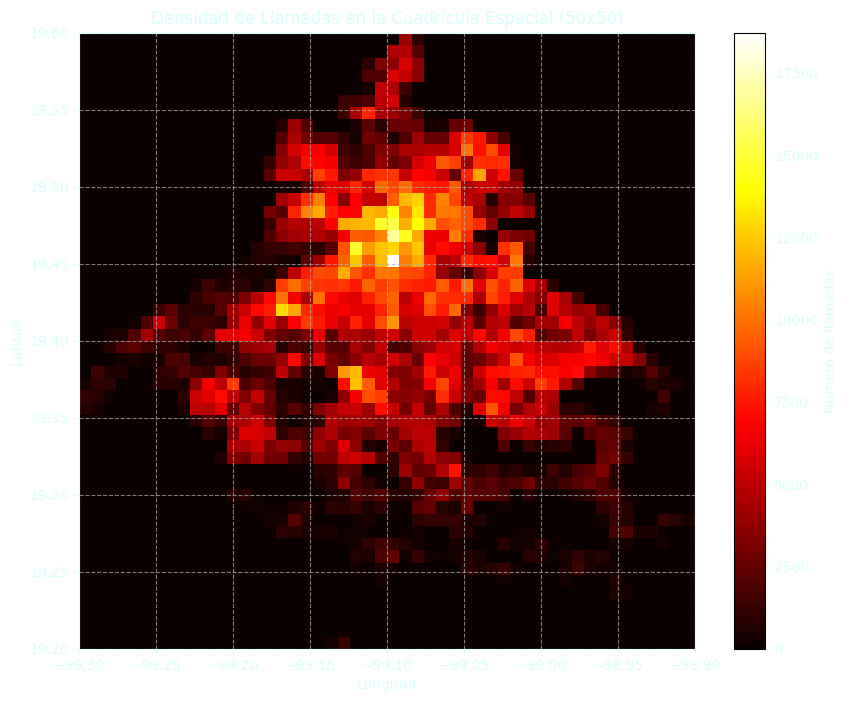

In [59]:
# Suponiendo que 'df_llamadas' tiene columnas 'latitud' y 'longitud'
lat_min, lat_max = df_llamadas['latitud'].min(), df_llamadas['latitud'].max()
lon_min, lon_max = df_llamadas['longitud'].min(), df_llamadas['longitud'].max()

# Definir el número de celdas en la cuadrícula
grid_size = 50

# Crear una matriz para contar la densidad de llamadas
density_matrix = np.zeros((grid_size, grid_size))

# Calcular los índices de las celdas para cada llamada
lat_bins = np.linspace(lat_min, lat_max, grid_size + 1)
lon_bins = np.linspace(lon_min, lon_max, grid_size + 1)

# Asignar cada llamada a una celda de la cuadrícula
lat_indices = np.digitize(df_llamadas['latitud'], bins=lat_bins) - 1
lon_indices = np.digitize(df_llamadas['longitud'], bins=lon_bins) - 1

# Contar la cantidad de llamadas en cada celda
for lat_idx, lon_idx in zip(lat_indices, lon_indices):
    if 0 <= lat_idx < grid_size and 0 <= lon_idx < grid_size:
        density_matrix[lat_idx, lon_idx] += 1

# Graficar la densidad de llamadas en la cuadrícula
plt.figure(figsize=(10, 8))
im = plt.imshow(density_matrix, cmap='hot', extent=[-99.3, -98.9, 19.2, 19.6], origin='lower')

# Ajustar color del texto, fondo, y cambiar la escala de colores
plt.title('Densidad de Llamadas en la Cuadrícula Espacial (50x50)', color='#DAFFFB')
plt.xlabel('Longitud', color='#DAFFFB')
plt.ylabel('Latitud', color='#DAFFFB')

# Cambiar el color de los ejes a #DAFFFB
plt.gca().spines['top'].set_color('#DAFFFB')
plt.gca().spines['bottom'].set_color('#DAFFFB')
plt.gca().spines['left'].set_color('#DAFFFB')
plt.gca().spines['right'].set_color('#DAFFFB')

# Cambiar el color de los ticks a #DAFFFB
plt.gca().tick_params(axis='x', colors='#DAFFFB')
plt.gca().tick_params(axis='y', colors='#DAFFFB')

# Añadir la barra de color y cambiar el color del texto
cbar = plt.colorbar(im)
cbar.set_label('Número de llamadas', color='#DAFFFB')
cbar.ax.yaxis.set_tick_params(color='#DAFFFB')  # Cambiar el color de los ticks en la barra de color
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#DAFFFB')  # Cambiar el color de las etiquetas de los ticks

plt.grid(True, linestyle='--', alpha=0.7)

# Guardar como PNG con fondo transparente
plt.savefig('densidad_llamadas.png', transparent=True)
plt.show()

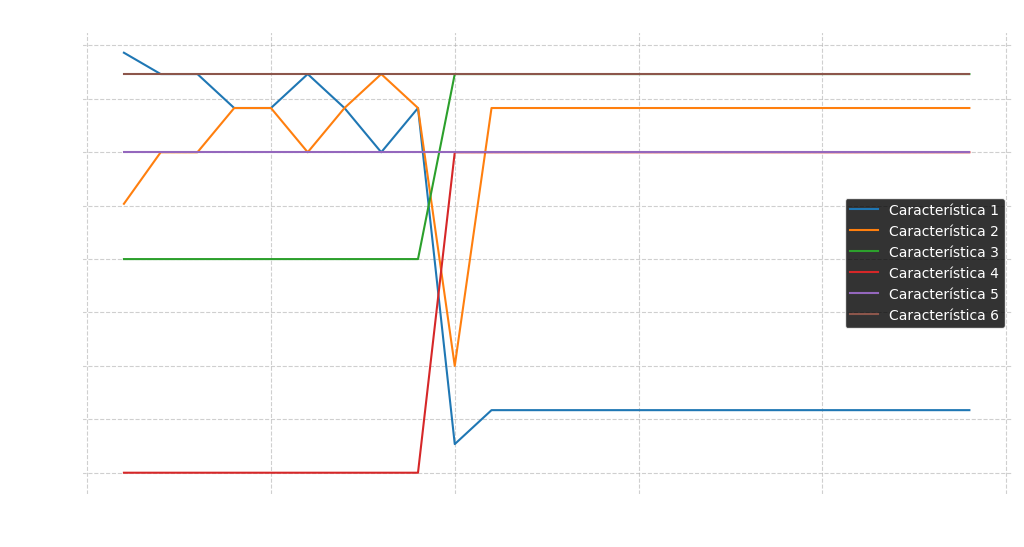

In [37]:
import matplotlib.pyplot as plt

# Secuencia de ejemplo
indice_ejemplo = 78
secuencia_ejemplo = X_lstm[indice_ejemplo]

# Crear una figura para visualizar la secuencia temporal
plt.figure(figsize=(12, 6))
for i in range(secuencia_ejemplo.shape[1]):
    plt.plot(range(1, len(secuencia_ejemplo) + 1), secuencia_ejemplo[:, i], label=f'Característica {i + 1}')

plt.xlabel('Paso de Tiempo', color='white')
plt.ylabel('Valor Normalizado', color='white')
plt.title('Ejemplo de Secuencias Temporales Utilizadas en el LSTM', color='white')
plt.legend(facecolor='black', edgecolor='white', labelcolor='white')
plt.grid(True, linestyle='--', alpha=0.6)

# Cambiar el color de los ejes y ticks a blanco
plt.gca().spines['top'].set_color('white')
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().tick_params(axis='x', colors='white')
plt.gca().tick_params(axis='y', colors='white')

# Guardar la figura como PNG con fondo transparente
plt.savefig('secuencia_temporal_lstm.png', transparent=True)

plt.show()

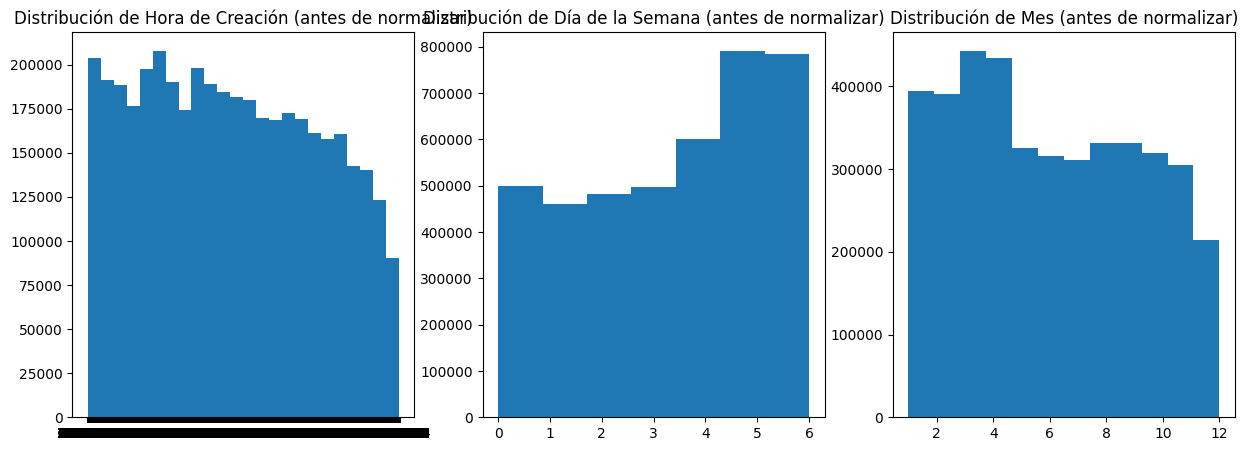

In [ ]:
# import matplotlib.pyplot as plt

# # Verificar la distribución antes de la normalización
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1)
# plt.hist(df_llamadas['hora_creacion'], bins=24)
# plt.title('Distribución de Hora de Creación (antes de normalizar)')

# plt.subplot(1, 3, 2)
# plt.hist(df_llamadas['dia_semana'], bins=7)
# plt.title('Distribución de Día de la Semana (antes de normalizar)')

# plt.subplot(1, 3, 3)
# plt.hist(df_llamadas['mes'], bins=12)
# plt.title('Distribución de Mes (antes de normalizar)')

# plt.show()

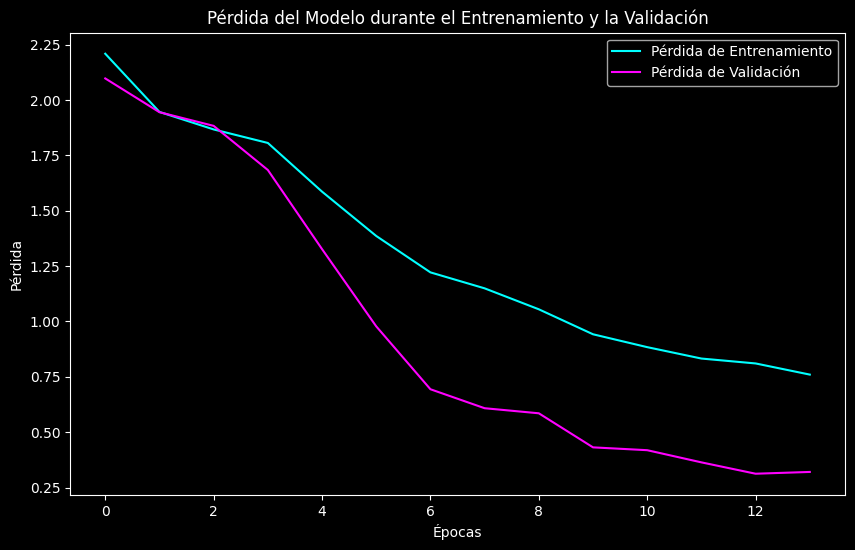

In [45]:
import matplotlib.pyplot as plt

# Cambiar el estilo de la figura para tener un fondo oscuro y texto blanco
plt.style.use('dark_background')

# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(10, 6))

# Graficar la pérdida del entrenamiento con color cian
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento', color='cyan')

# Graficar la pérdida de la validación con color magenta
plt.plot(history.history['val_loss'], label='Pérdida de Validación', color='magenta')

# Añadir título y etiquetas a los ejes con color blanco
plt.title('Pérdida del Modelo durante el Entrenamiento y la Validación', color='white')
plt.xlabel('Épocas', color='white')
plt.ylabel('Pérdida', color='white')

# Añadir leyenda
plt.legend()

# Guardar la figura como PNG
plt.savefig('pérdida_entrenamiento_validación.png', format='png', transparent=True)

# Mostrar la gráfica
plt.show()